In [744]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [745]:
#zf = zipfile.ZipFile('chicago-food-inspections.zip')
#dblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))

In [746]:
#dblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)

In [747]:
#dblp.to_csv(r'food_inspections.csv')

In [748]:
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))

In [749]:
#cleaning the dataset removing Nan valued rows
print(df['Facility Type'].size)
print(df['Facility Type'].dropna().size)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)



196030
191258


We realised that we will need Facility Type in most of our analysis so we dropped the rows that were missing this data


In [750]:
print(df.size)
df = df[~df.Results.str.contains("Not Ready")]
print(df.size)

1863719
1863056


In [751]:
df.reset_index().head()

,index,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,Risk 1 (High),60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,Risk 2 (Medium),60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,Risk 1 (High),60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,Risk 3 (Low),60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,Risk 1 (High),60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


In [752]:
print(df.loc[7330])

Unnamed: 0                                                      9833
Inspection ID                                                2285553
DBA Name                                                EL TACONZAZO
License #                                                 2.0596e+06
Facility Type                                             Restaurant
Risk                                                   Risk 1 (High)
Zip                                                            60632
Inspection Date                              2019-04-22T00:00:00.000
Inspection Type                                              Canvass
Results                                           Pass w/ Conditions
Violations         3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...
Latitude                                                     41.7992
Longitude                                                   -87.7232
Name: 7330, dtype: object


In [753]:
df = df[df.Risk.str.contains("[1-3]",na=False)]
df['Risk'] = df.Risk.apply(lambda x: int(x.strip('Risk')[1]))
df.head()



,Unnamed: 0,Inspection ID,DBA Name,License #,Facility Type,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,0,2345787,"CARNICERIA LEON GUANAJUATO, INC.",1821637.0,Grocery Store,1,60639.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.916960,-87.733945
1,1,2345790,AMSTAR FUEL & MINI MART,1426374.0,Grocery Store,2,60651.0,2019-11-18T00:00:00.000,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.895304,-87.721129
2,2,2345766,ROJO GUSANO,1305286.0,Restaurant,1,60625.0,2019-11-18T00:00:00.000,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968390,-87.724448
3,3,2345702,LAKESIDE FOOD WINE SPIRITS LLC,2694148.0,Grocery Store,3,60614.0,2019-11-15T00:00:00.000,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.929210,-87.648746
4,4,2345678,"NEW KNOWLEDGE LEARNING CENTER, INC.",2215898.0,Children's Services Facility,1,60652.0,2019-11-15T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.739458,-87.702257


In [754]:
df['Facility Type'] = df['Facility Type'].str.lower()
df['Facility Type'] = df['Facility Type'].str.replace('[()]', '')


In [755]:
#TODO : Grocery Store and Restaurant are going to be unified
'''
dp = df[df['Facility Type'].str.contains("grocery") & df['Facility Type'].str.contains("restaurant")]
dp.loc[:,'Facility Type'] = 'grocery and restaurant'
df = df[~df['Facility Type'].str.contains("grocery") & df['Facility Type'].str.contains("restaurant")]
'''
#df = df.append(dp,ignore_index=False)


'\ndp = df[df[\'Facility Type\'].str.contains("grocery") & df[\'Facility Type\'].str.contains("restaurant")]\ndp.loc[:,\'Facility Type\'] = \'grocery and restaurant\'\ndf = df[~df[\'Facility Type\'].str.contains("grocery") & df[\'Facility Type\'].str.contains("restaurant")]\n'

In [756]:
#aggregating over Facility Types
grouped_fac = df.groupby('Facility Type')

In [757]:
#facility vs average risk
grouped_fac_risk_mean = pd.DataFrame(grouped_fac['Risk'].mean()).reset_index()
grouped_fac_risk_mean.head()

,Facility Type,Risk
0,1005 nursing home,1.0
1,1023,1.0
2,1023 childern's service facility,1.0
3,1023 childern's service s facility,1.0
4,1023 childern's services facility,1.0


## Facility Type vs. Average Risk
We realized that this plot is not meaningful due to the number of Facility Types(438 in total). 

In [758]:
# facility type distribution
fac_dist = pd.DataFrame(grouped_fac.count()['Risk']).rename(columns={'Risk':'Counts'}).sort_values(by='Counts',ascending=False).reset_index()
print(fac_dist.size)
fac_dist.head(100)


750


,Facility Type,Counts
0,restaurant,98720
1,grocery store,18023
2,school,10402
3,children's services facility,2370
4,bakery,2177
...,...,...
95,grocery& restaurant,9
96,grocery/gas station,9
97,wrigley roof top,9
98,banquet dining,9


In [768]:
merged_inner = pd.merge(left=fac_dist,right=grouped_fac_risk_mean,left_on='Facility Type',right_on='Facility Type')

plt.plot(fac_dist['Counts'],grouped_fac_risk_mean['Risk'])

,Facility Type,Counts,Risk
0,restaurant,98720,1.186335
1,grocery store,18023,1.954225
2,school,10402,1.115170
3,children's services facility,2370,1.005907
4,bakery,2177,1.586587



We have realised that the dataset is unbalanced in terms of number of Facility Types. Hence, we decided to analyse the first 50 most frequent type of facilities and drop the others.

In [760]:

print(df.size)
df = df[df['Facility Type'].isin(list(fac_dist['Facility Type'])[:50])]
print(df.size)


1863056
1844440


As we can see from the code above, there are around 20 thousand facilities that dont have as much inspections as the others. As a result, data set is more balanced now

In [761]:
#out of business facilities

df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
#grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name']).count()

In [762]:
mapp = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=5
)


marker_cluster = MarkerCluster().add_to(mapp)
ranges = 0
for i in df_oob_unique.index:
    if ranges == 6000:
        break
    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)
        
    ranges = ranges + 1
    
 
 




mapp


In [763]:
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

In [764]:

map_riskli = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)


ranges = 0
for i in df_avg_risk_score.index:
    if ranges == 1000:
        break
    if(round(df_avg_risk_score[i]) == 1):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red', )).add_to(map_riskli)
    elif(round(df_avg_risk_score[i]) == 2):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange', )).add_to(map_riskli)
    elif(round(df_avg_risk_score[i]) == 3):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green', )).add_to(map_riskli)
    
        
    ranges = ranges + 1

map_riskli

We observed that the number of risk 3 facilities are lower than the others. Hence, we have decided to plot **average risk scores vs number of facilities

In [765]:
#Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1



,Counts
Risk,
1.0,15023
2.0,5938
3.0,3633


<BarContainer object of 3 artists>

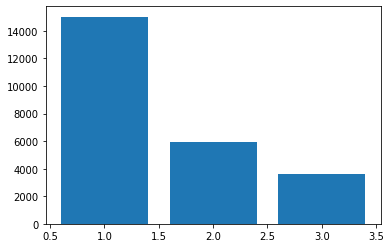

In [766]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'])

Her yer pislik içinde şikago sıkıntı (imamhatipler kapatılsın)